In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(".")

from scripts.rkhs_test import RKHSTester
import torch
from torch.utils.data import DataLoader
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from context._noise import Noise

class MMDTester:
    """
    Compares a dataset to a Gaussian Process distribution by calculating
    the Maximum Mean Discrepancy (MMD) between them.
    This version uses the median heuristic to set the MMD kernel bandwidth.
    """

    def __init__(self, noise_sampler: 'Noise'):
        """
        Initializes the tester.
        """
        self.noise_sampler = noise_sampler
        self.device = noise_sampler.device
        # The MMD kernel bandwidth will be set dynamically for each batch.
        self.mmd_kernel_bandwidth = None
        print(
            f"Initialized MMDTester with GP length scale: {noise_sampler.config["noise"]["len"]:.4f}")

    def _set_mmd_bandwidth(self, X: torch.Tensor, Y: torch.Tensor):
        """
        Calculates and sets the MMD kernel bandwidth using the median heuristic.
        """
        # Combine samples from both distributions
        all_samples = torch.cat([X, Y], dim=0)
        # Calculate squared pairwise distances
        distances_sq = torch.cdist(all_samples, all_samples, p=2)**2
        # Get the median of the non-zero distances and set bandwidth
        median_dist_sq = torch.median(distances_sq[distances_sq > 0])
        self.mmd_kernel_bandwidth = torch.sqrt(median_dist_sq).item()

    def _rbf_kernel(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        """
        Computes the RBF kernel matrix between two sets of samples.
        """
        distances_sq = torch.cdist(X, Y, p=2)**2
        gamma = 1.0 / (2 * self.mmd_kernel_bandwidth**2)
        kernel_matrix = torch.exp(-gamma * distances_sq)
        return kernel_matrix

    def compute_mmd(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        """
        Computes the unbiased squared MMD estimator.
        """
        # Set the bandwidth based on the current batch of data
        self._set_mmd_bandwidth(X, Y)

        K_XX = self._rbf_kernel(X, X)
        K_YY = self._rbf_kernel(Y, Y)
        K_XY = self._rbf_kernel(X, Y)

        n = K_XX.shape[0]
        if n <= 1: return torch.tensor(0.0, device=self.device)
        
        term_xx = (K_XX.sum() - K_XX.diag().sum()) / (n * (n - 1))
        term_yy = (K_YY.sum() - K_YY.diag().sum()) / (n * (n - 1))
        term_xy = K_XY.mean() * 2

        return term_xx + term_yy - term_xy

    def test_batch(self, batch_data: torch.Tensor) -> torch.Tensor:
        """
        Calculates the MMD between a batch of real data and a batch of
        synthetic data generated from this tester's GP.
        """
        B, C, H, W = batch_data.shape
        batch_flat = batch_data.view(B * C, -1)
        
        num_samples = batch_flat.shape[0]
        if num_samples <= 1: return torch.tensor(0.0, device=self.device)

        generated_samples = self.noise_sampler.sample(num_samples).to(self.device)
        generated_flat = generated_samples.view(num_samples, -1)

        md_value = self.compute_mmd(batch_flat, generated_flat)
        return md_value


In [4]:
from numpy import log10
from context._noise import Noise
from tqdm import tqdm
from my_datasets import get_dataset


train_dataset = get_dataset("darcy", phase="train",
                            target_resolution=64, layout="product")

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0)


result = {}

for len in np.logspace(log10(0.001), np.log10(0.2), 5):
    noise = Noise({
        "noise": {
            "gain": 1.0,
            "len": len,
        },
        "device": "cuda",
        "dimensions": 2,
        "resolution": 64
    })  # type: ignore
    tester = MMDTester(noise)

    losses = []

    for i, x in enumerate(tqdm(train_loader)):
        x0, x1 = x

        x = torch.concat((x0, x1), dim=1).to(
            device="cuda", dtype=torch.float32)
        # x = x0.to(device="cuda", dtype=torch.float32)
        # x = x1[:, 1, None, None, :].to(device="cuda", dtype=torch.float32)
        # x = x1.to(device="cuda", dtype=torch.float32)

        res = tester.test_batch(x)

        losses.append(res.mean().item())

        if i >= 10:
            break

    result[len] = np.mean(losses)

print(result)
plt.xscale("log")
plt.plot(result.keys(), [r * 1.0 for r in result.values()])
df = pd.DataFrame({
    "x": list(result.keys()),
    "l2err_forward": [r * 1.0 for r in result.values()]
})

GOING FOR `./data/darcy`!


Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

TypeError: Noise.__init__() missing 1 required positional argument: 'override_len'

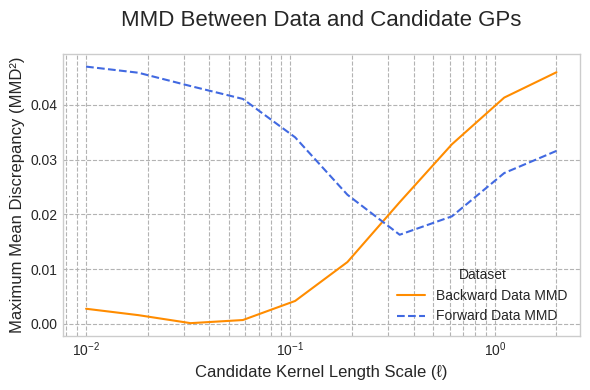

In [ ]:
# # --- Plotting the data ---

# # Set up the plot style and figure size
# plt.style.use('seaborn-v0_8-whitegrid')
# fig, ax = plt.subplots(figsize=(6, 4))

# # Plot the two lines with enhanced styling
# ax.plot(result.keys(), result.values(), linestyle='-', color='darkorange',
#         label='Backward Data MMD', markerfacecolor='moccasin', markersize=8)

# ax.plot(result_forward.keys(), result_forward.values(), linestyle='--', color='royalblue',
#         label='Forward Data MMD', markerfacecolor='lightblue', markersize=8)

# # --- Customizing the plot ---

# # Set the x-axis to a logarithmic scale
# ax.set_xscale("log")

# # Set title and labels
# ax.set_title('MMD Between Data and Candidate GPs', fontsize=16, pad=20)
# ax.set_xlabel('Candidate Kernel Length Scale (ℓ)', fontsize=12)
# ax.set_ylabel('Maximum Mean Discrepancy (MMD²)', fontsize=12)

# # Add a legend to identify each curve
# ax.legend(title='Dataset', fontsize=10)

# # Add grid lines for better readability
# ax.grid(True, which="both", ls="--", c='0.7')

# # Improve layout
# plt.tight_layout()

# # Save the figure to a file
# plt.savefig("mmd_results_plot_darcy2d.png", dpi=300)

# # Display the plot
# plt.show()